In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import scipy.stats as st
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from storage import get_storage_functions
from local_paths import preproc_dir, analysis_dir

# Parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# saccade-matching
#============================================================================
min_sep = 4  # for non-matched fixation


#============================================================================
# response windows
#============================================================================
t_pre  = 375
t_post = 375
t_step =  10


#============================================================================
# statistics
#============================================================================
match_tests = (
    (('Non', 'Face'), 'previous', 'greater'),
    (('Face', 'Non'), 'current', 'greater'))


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir

sdf_dir = preproc_dir
sdf_suffix = '-mwa_50'

fsn_dir = analysis_dir + 'face_specific'

rsc_dir = analysis_dir + 'self_consistency_no_decorr'

output_dir = analysis_dir + 'face_specific_match_control'

In [3]:
# Parameters
sess_name = "Pa210201"
fsn_dir = "../test_results"
output_dir = "../test_results"


# Check parameters and whether already done

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

fsn_path = Path(fsn_dir) / (sess_name + '.h5')
print('Loading face-specific (per unit) results from', fsn_path)
fsn_path = fsn_path.expanduser()
assert fsn_path.is_file()

rsc_path = Path(rsc_dir) / (sess_name + '.h5')
print('Loading return fixation self-consistency results from', rsc_path)
rsc_path = rsc_path.expanduser()
assert rsc_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading spike density function from ../test_data/Pa210201-sdf-mwa_50.h5
Loading face-specific (per unit) results from ../test_results/Pa210201.h5
Loading return fixation self-consistency results from ../test_results/self_consistency_no_decorr/Pa210201.h5
Saving results to ../test_results/Pa210201.h5


In [5]:
analysis_name = 'face_specific_match_control'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [6]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [7]:
group = analysis_name + '/config/'
save_results(group+'sdf_suffix', sdf_suffix)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_pre',  t_pre)
save_results(group+'t_post',  t_post)
save_results(group+'t_step',  t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/statistics/'
save_results(group+'tests', str(match_tests))
save_results(group+'test_kind', 'mannwhitneyu')

# Categorize fixations using ROIs

In [8]:
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]

group = 'face_specific/'
cat_df = pd.read_hdf(fsn_path, group+'categorization').set_index(['Group', 'Fixation index'])
cls_df = pd.read_hdf(fsn_path, group+'cluster_id').set_index(['Group', 'Fixation index'])
with h5.File(fsn_path, 'r') as f:
    unit_names = f[group+'unit_names'][()].astype(str)
    face_cats = list(f[group+'config/face_cats'][()].astype(str))
    group_ = f[group+'unit_groups']
    unit_groups = [group_[str(i)][()] for i in range(len(group_.keys()))]

face_cats_ = list(set(cat_df.columns) & set(face_cats))
cat_df['Is non'] = ~cat_df.values.any(1)
cat_df['Is face'] = cat_df[face_cats_].values.any(1)

In [9]:
save_results(analysis_name+'/unit_names', unit_names.astype(bytes))
for igroup, usel in enumerate(unit_groups):
    save_results(group+f'unit_groups/{igroup}', usel)

# Find match for saccades

In [10]:
bycond_return_pairs = {}

with h5.File(proc_path, 'r') as f:
    sacc_sel = f['saccade_selection/fixation_indices'][()]  # shape (n, 2)
    lg_sacc_mask = f['saccade_selection/large/saccade_subset'][()]  # shape (n,) bool mask

with h5.File(rsc_path, 'r') as f:
    return_thres = f['self_consistency/config/return_criterion/return_thres'][()]
    group = f['self_consistency/return_pairs']
    for k, v in group.items():
        if not k in {v[1] for v in match_tests}: continue
        v = v[()]
        if not v.size: continue
        v = np.sort(v, axis=1)
        v = v[np.lexsort(tuple(v.T))]
        bycond_return_pairs[k] = v

# exclude saccades starting at fix 0 to avoid onset-transient
fix_ords = fix_df.index.get_level_values(fix_df.index.names.index('Fixation'))
non_zeroth = fix_ords[sacc_sel[0]] != 0
non_zeroth = np.nonzero(non_zeroth)[0]
for k, v in bycond_return_pairs.items():
    m = pd.Series(v[:,0]).isin(non_zeroth).values & pd.Series(v[:,1]).isin(non_zeroth).values
    bycond_return_pairs[k] = v = v[m]

In [11]:
group = 'face_specific/by_saccade/by_saccade_size/'
with h5.File(fsn_path, 'r') as f:
    sconds = list(f[group].keys())
byscond_sacc_cat_dfs = {
    scond: pd.read_hdf(fsn_path, group+scond+'/saccade_categorization').reset_index().drop(columns='index')
    for scond in sconds}

In [12]:
byscond_bytest_match_sacc_df = {}

for scond, sacc_cat_df in byscond_sacc_cat_dfs.items():
    matched_frac = []
    if scond == 'all':
        sacc_mask = None
    elif scond == 'large':
        sacc_mask = lg_sacc_mask
    else:
        raise ValueError('Unknown saccade condition: '+scond)

    byscond_bytest_match_sacc_df[scond] = {}
    for test in match_tests:
        byscond_bytest_match_sacc_df[scond][test] = {}
        match_sacc_df = []

        ofix = ['previous', 'current'].index(test[1])
        match_cat = test[0][ofix].lower()  # category of matched fixation
        match_other_cat = test[0][1-ofix].lower()  # category of the other fixation in sacc
        assert f'Is {match_cat}' in cat_df.columns
        assert f'Is {match_other_cat}' in cat_df.columns

        for igroup, df1 in tqdm(sacc_cat_df.groupby('Group')):
            assert not df1.index.has_duplicates

            for scat, df2 in df1.groupby(['Fix 1 cat', 'Fix 2 cat']):
                # skip saccade categories unrelated to test
                if scat != test[0]:
                    continue

                # ordinal (1st or 2nd) of fixation to be matched
                src_ifixs = df2[f'Fix {ofix+1} index'].values
                src_other_ifixs = df2[f'Fix {1-ofix+1} index'].values

                # matched pairs; contains 2-tuples of indexing into sacc_sel
                pairs = bycond_return_pairs[test[1]]

                # chose a match for each fixation in a matched src pair
                matched = np.zeros(len(src_ifixs), dtype=bool)
                match_isaccs = np.empty(len(src_ifixs), dtype=int)  # indexing into sacc_sel

                rg = np.random.default_rng(random_seed)
                for i, (ifix, other_ifix) in enumerate(zip(src_ifixs, src_other_ifixs)):
                    opts = np.nonzero((sacc_sel[ofix,pairs] == ifix).any(1))[0]
                    if not opts.size: continue
                    src_xy, src_other_xy = fix_df.iloc[[ifix, other_ifix]][['Relative X', 'Relative Y']].values
                    src_sacc_size = np.linalg.norm(src_xy - src_other_xy)

                    rg.shuffle(opts)
                    for opt in opts:
                        pair_ifixs = sacc_sel[:,pairs[opt]].T  # (2, 2) rows = sacc1 sacc2, cols = fix1 fix2

                        isrc = np.nonzero(pair_ifixs[:,ofix] == ifix)[0].item()  # which of the pair is the source (to-be-paired)

                        # require match saccade to be included under sacc_mask (if any)
                        if sacc_mask is not None and not sacc_mask[pairs[opt][1-isrc]]:
                            continue

                        match_ifix, match_other_ifix = pair_ifixs[1-isrc][[ofix,1-ofix]]

                        # matched fixation must have the same categorization
                        # (in addition to being return-paired)
                        try:
                            row = cat_df.loc[(igroup, match_ifix)]
                            check = row[f'Is {match_cat}']
                        except KeyError:
                            check = False
                        if not check:
                            continue

                        # non-matched fixation must have different categorization
                        try:
                            row = cat_df.loc[(igroup, match_other_ifix)]
                            check = not row[f'Is {match_other_cat}']
                        except KeyError:
                            check = False  # alright if no category for other fix
                        if not check:
                            continue

                        # non-matched fixation must not be close by
                        match_xy, match_other_xy = fix_df.iloc[[match_ifix, match_other_ifix]][['Relative X', 'Relative Y']].values
                        if np.linalg.norm(src_other_xy - match_other_xy) < min_sep:
                            continue

                        matched[i] = True
                        match_isaccs[i] = pairs[opt,1-isrc]
                        break

                matched_frac.append(matched)
                assert (match_isaccs[matched] >= 0).all()  # not using uint because pandas doesn't play well with it
                df_out = pd.DataFrame(
                    data={'Match saccade index': match_isaccs[matched]},
                    index=df2.index[matched])
                df_out['Group'] = igroup
                match_sacc_df.append(df_out)

        byscond_bytest_match_sacc_df[scond][test] = pd.concat(match_sacc_df)
        print(scond, 'saccades, test:', test)
        m = np.concatenate(matched_frac)
        print(f'fraction of matched saccades matched: {m.mean()*1e2:.2f}% ({m.sum()} of {m.size})')

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.30it/s]

all saccades, test: (('Non', 'Face'), 'previous', 'greater')
fraction of matched saccades matched: 17.79% (1224 of 6881)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 12.43it/s]

all saccades, test: (('Face', 'Non'), 'current', 'greater')
fraction of matched saccades matched: 18.38% (2635 of 14338)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.39it/s]

large saccades, test: (('Non', 'Face'), 'previous', 'greater')
fraction of matched saccades matched: 11.95% (676 of 5658)


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.02it/s]

large saccades, test: (('Face', 'Non'), 'current', 'greater')
fraction of matched saccades matched: 11.58% (1331 of 11498)


In [13]:
save_results(analysis_name+'/saccade_selection/fixation_indices', sacc_sel)
save_results(analysis_name+'/saccade_selection/large/saccade_subset', lg_sacc_mask)

for scond, sacc_cat_dfs in byscond_sacc_cat_dfs.items():
    group = analysis_name + '/by_saccade_size/' + scond + '/'
    kwargs = dict(mode='a', format='table', complevel=9, complib='zlib')

    sacc_cat_dfs.to_hdf(output_path, group+'saccade_categorization', **kwargs)
    for itest, test in enumerate(match_tests):
        byscond_bytest_match_sacc_df[scond][test].to_hdf(
            output_path, group+'match_saccades/'+str(test), **kwargs)

/home/will/.local/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: "(('Non', 'Face'), 'previous', 'greater')"; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/will/.local/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: "(('Face', 'Non'), 'current', 'greater')"; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## Sanity check

In [14]:
for scond, sacc_cat_df in byscond_sacc_cat_dfs.items():
    for test in match_tests:
        match_sacc_df = byscond_bytest_match_sacc_df[scond][test]
        ofix = ['previous', 'current'].index(test[1])
        match_cat = test[0][ofix].lower()  # category of matched fixation
        match_other_cat = test[0][1-ofix].lower()  # category of the other fixation in sacc

        for igroup, mdf in tqdm(match_sacc_df.groupby('Group')):
            df1 = sacc_cat_df[sacc_cat_df['Group']==igroup]

            src_ifixs = df1.loc[mdf.index][['Fix 1 index', 'Fix 2 index']].values  # (n, 2)
            match_ifixs = sacc_sel[:,mdf['Match saccade index'].values].T  # (n, 2)

            # zeroth fixations should not be included
            assert not (fix_ords[src_ifixs[:,0]] == 0).any()
            assert not (fix_ords[match_ifixs[:,0]] == 0).any()

            # matched fixations must be close
            src_xys = fix_df.iloc[src_ifixs[:,ofix]][['Relative X', 'Relative Y']].values  # (n, 2)
            match_xys = fix_df.iloc[match_ifixs[:,ofix]][['Relative X', 'Relative Y']].values  # (n, 2)
            assert (return_thres >= np.linalg.norm(src_xys - match_xys, axis=-1)).all()

            # non-matched fixations must be far
            src_other_xys = fix_df.iloc[src_ifixs[:,1-ofix]][['Relative X', 'Relative Y']].values  # (n, 2)
            match_other_xys = fix_df.iloc[match_ifixs[:,1-ofix]][['Relative X', 'Relative Y']].values  # (n, 2)
            assert (min_sep <= np.linalg.norm(src_other_xys - match_other_xys, axis=-1)).all()

            # matched category must be same
            idc = pd.MultiIndex.from_arrays([np.full(len(match_ifixs),igroup), src_ifixs[:,ofix]])
            src_cat = cat_df[f'Is {match_cat}'].reindex(idc).values
            # may have duplicate indices so cannot use .loc
            idc = pd.MultiIndex.from_arrays([np.full(len(match_ifixs),igroup), match_ifixs[:,ofix]])
            match_cat_ = cat_df[f'Is {match_cat}'].reindex(idc).values
            assert src_cat.all() and match_cat_.all()

            # non-matched category must be different
            idc = pd.MultiIndex.from_arrays([np.full(len(match_ifixs),igroup), src_ifixs[:,1-ofix]])
            src_cat = cat_df[f'Is {match_other_cat}'].reindex(idc).values
            idc = pd.MultiIndex.from_arrays([np.full(len(match_ifixs),igroup), match_ifixs[:,1-ofix]])
            match_cat_ = cat_df[f'Is {match_other_cat}'].reindex(idc, fill_value=False).values
            assert src_cat.all() and not match_cat_.any()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 198.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 197.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 195.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 201.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 170.20it/s]

# Load neural data

In [15]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    all_unit_names = list(dset.attrs['unit_names'].astype(str))
    sel_ = np.array([all_unit_names.index(n) for n in unit_names])
    sdf = dset[()][:,sel_]

n_neur = len(unit_names)

# Across-saccade analysis: PSTHs

In [16]:
byscond_psth_mean_std = {}
byscond_pvals = {}
byscond_nsaccs = {}
ts = np.arange(-t_pre, t_post+t_step/10, t_step)

for scond, sacc_cat_df in byscond_sacc_cat_dfs.items():
    n_test = len(match_tests)
    # shape (n_test, src/match, mean/std, time, unit)
    byscond_psth_mean_std[scond] = psth_mean_std = \
        np.full((n_test, 2, 2, ts.size, n_neur), np.nan, dtype=sdf.dtype)
    # shape (n_test, time, unit)
    byscond_pvals[scond] = pvals = \
        np.full((n_test, ts.size, n_neur), np.nan, dtype=sdf.dtype)
    byscond_nsaccs[scond] = nsaccs = np.zeros((n_test, n_neur), dtype=int)

    for itest, test in enumerate(match_tests):
        match_sacc_df = byscond_bytest_match_sacc_df[scond][test]

        for igroup, df1_ in tqdm(sacc_cat_df.groupby('Group')):
            mdf = match_sacc_df[match_sacc_df['Group']==igroup]
            assert not any(df.index.has_duplicates for df in (df1_, mdf))
            df1 = df1_.loc[mdf.index]
            usel = unit_groups[igroup]

            n_sacc = len(mdf)
            paired_psths = np.empty((2, n_sacc, ts.size, usel.size), dtype=sdf.dtype)
            for j, ifix2s in enumerate((
                    df1['Fix 2 index'].values,
                    sacc_sel[0,mdf['Match saccade index'].values]
            )):
                for i, t in enumerate(fix_df.iloc[ifix2s]['Time'].values):
                    ts_ = np.round(t+ts).astype(int)
                    # if not i: print(ts_)
                    paired_psths[j,i] = sdf[ts_,:][:,usel]
            psth_mean_std[itest,:,0,:,usel] = paired_psths.mean(1).transpose(2,0,1)  # transpose due to
            psth_mean_std[itest,:,1,:,usel] = paired_psths.std(1).transpose(2,0,1)   # numpy indexing weirdness
            nsaccs[itest,usel] = n_sacc

            if n_sacc < 2:
                continue

            try:
                pvals[itest,:,usel] = st.wilcoxon(
                    *paired_psths,
                    alternative=test[2],
                    axis=0
                ).pvalue.T  # transpose due to numpy indexing weirdness
            except ValueError as e:
                if 'x - y is zero for all elements' not in str(e):
                    raise

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 45.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 48.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 61.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.62it/s]

In [17]:
dims = np.array(('test', 'cond', 'statistic', 'time', 'unit'))
coords = {
    'test': np.array([str(v) for v in match_tests]),
    'cond': np.array(('Original', 'Match')),
    'statistic': np.array(['mean', 'std']),
    'time': ts,
    'unit': unit_names}
compr = dict(compression='gzip', compression_opts=9)

for scond, psth_mean_std in byscond_psth_mean_std.items():
    group = analysis_name + f'/by_saccade_size/{scond}/'
    pvals = byscond_pvals[scond]
    nsaccs =  byscond_nsaccs[scond]
    data_vars = {
        'data': (dims, psth_mean_std),
        'p-value': (dims[[0,-2,-1]], pvals),
        'n_sacc': (dims[[0,-1]], nsaccs)}
    dataset = xr.Dataset(data_vars, coords=coords)
    dataset['data'].attrs.update({'unit': 'spikes/s'})

    encoding = {
        k: dict(chunksizes=v.shape, **compr) if v.size else {}
        for k, v in dataset.data_vars.items()}
    dataset.to_netcdf(
        output_path, group=group+'psth',
        mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [18]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [19]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:21:41.484811-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

h5py  : 3.8.0
pandas: 2.0.1
xarray: 2023.4.2
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy : 1.24.3
scipy : 1.10.1



# Basic visualization of results

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [21]:
f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))

### Quality control of matches

In [22]:
sacc_xy1s = fix_df.iloc[sacc_sel[0]][['Relative X', 'Relative Y']].values
sacc_xy2s = fix_df.iloc[sacc_sel[1]][['Relative X', 'Relative Y']].values
fix_xys = fix_df[['Relative X', 'Relative Y']].values

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 377.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 343.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 461.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 482.73it/s]

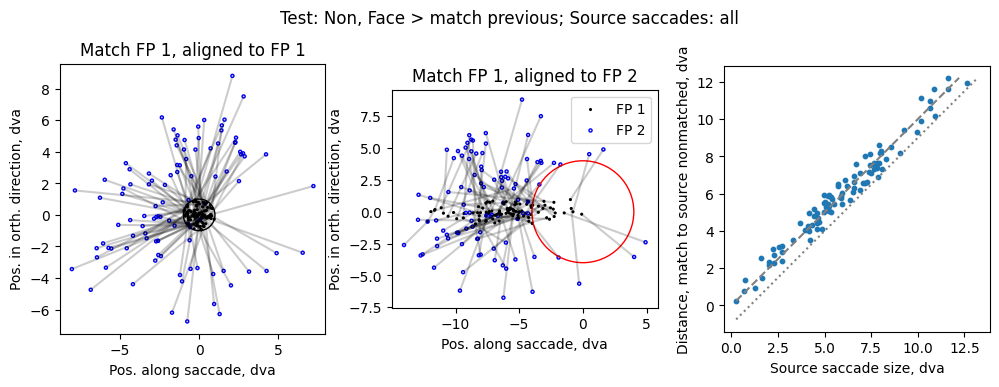

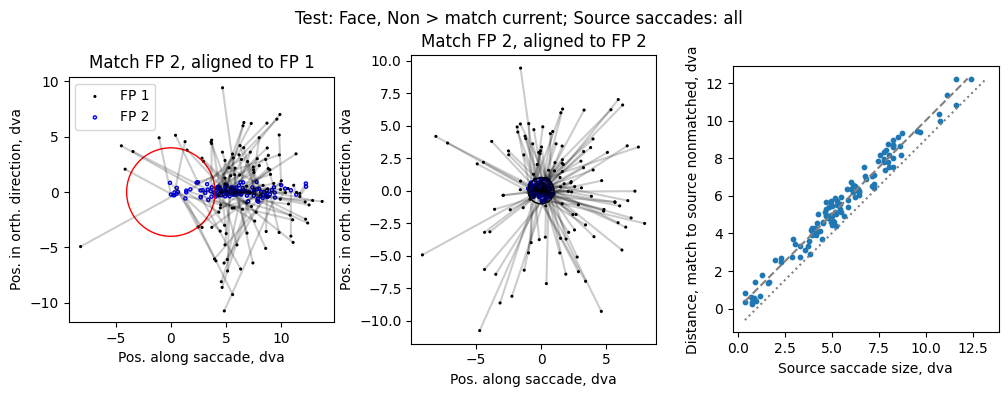

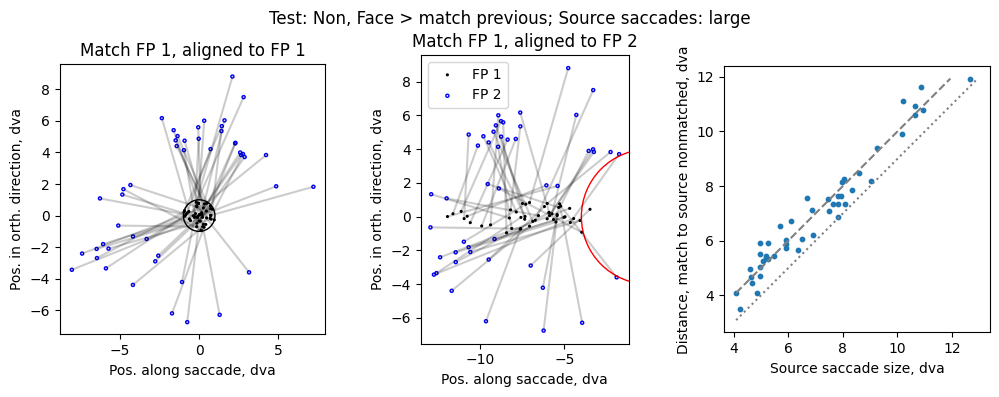

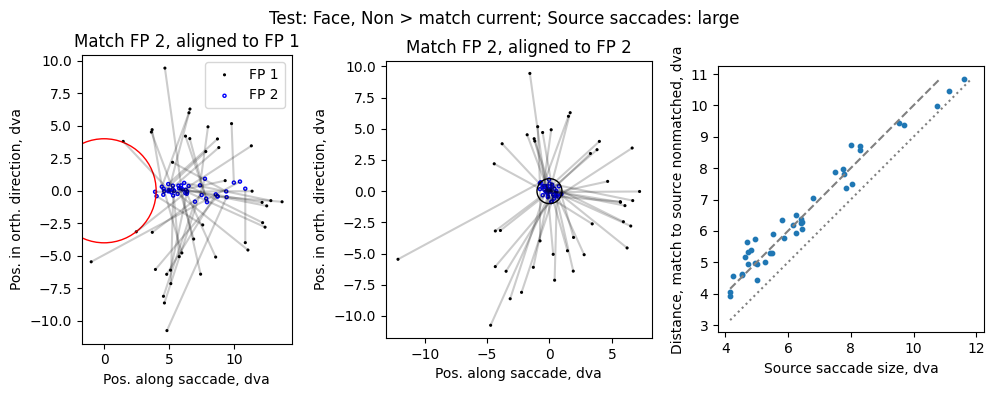

In [23]:
for scond, sacc_cat_df in byscond_sacc_cat_dfs.items():
    for itest, test in enumerate(match_tests):
        ofix = ['previous', 'current'].index(test[1])

        # tally all matches across units
        match_sacc_df = byscond_bytest_match_sacc_df[scond][test]
        if not match_sacc_df.size: continue
        matches = set()  # set of tuples: (src_ifix1, src_ifix2, matcH_isacc)
        for igroup, df1_ in tqdm(sacc_cat_df.groupby('Group')):
            mdf = match_sacc_df[match_sacc_df['Group']==igroup]
            df1 = df1_.loc[mdf.index]
            for (_, row), (_, mrow) in zip(df1.iterrows(), mdf.iterrows()):
                matches.add((row['Fix 1 index'], row['Fix 2 index'], mrow['Match saccade index']))

        # plot matches aligned to src matched fix
        fig, axs = plt.subplots(1, 3, figsize=(12,3.75))
        plt.subplots_adjust(wspace=0.25)
        fig.suptitle(f'Test: {f(test[0])} {dict(less="<",greater=">").get(test[2],"!=")} match {f(test[1])}; Source saccades: {scond}', y=1)

        sacc_sizes = []
        d_match_nonmatched = []
        for ii, (src_ifix1, src_ifix2, match_isacc) in enumerate(matches):
            xy1 = fix_xys[src_ifix1]
            xy2 = fix_xys[src_ifix2]
            mxy1 = sacc_xy1s[match_isacc]
            mxy2 = sacc_xy2s[match_isacc]

            v = xy2 - xy1
            mv = mxy2 - mxy1
            dm0 = mxy1 - xy1

            a = -np.arctan2(v[1], v[0])
            sina = np.sin(a)
            cosa = np.cos(a)
            R = np.array([[cosa, -sina], [sina, cosa]]).T
            rv = v @ R
            rmv = mv @ R
            rdm0 = dm0 @ R

            for i in range(2):
                offset = -rv if i else 0
                axs[i].plot(*(rdm0+offset+(np.array([[0,0],rmv]))).T, c='k', alpha=.2)
                axs[i].scatter(*(rdm0+offset), fc='k', ec='none', s=5, label=('FP 1',None)[(i!=ofix)&(ii>0)])  # match sacc start
                axs[i].scatter(*(rdm0+offset+rmv), ec='b', fc='none', s=5, label=('FP 2',None)[(i!=ofix)&(ii>0)])  # match sacc end

            sacc_sizes.append(np.linalg.norm(v))
            d_match_nonmatched.append(np.linalg.norm((xy2,xy1)[ofix]-(mxy1,mxy2)[ofix]))

        x, y = sacc_sizes, d_match_nonmatched
        axs[2].scatter(x, y, s=10)
        b = np.array([x,y])
        if b.size:
            b0, b1 = b.min(1).max(0), b.max(1).min(0)
            axs[2].plot([b0,b1], [b0,b1], color='gray', ls='--')
            axs[2].plot([b0,b1+return_thres], [b0-return_thres, b1], color='gray', ls=':')
        axs[2].set_xlabel('Source saccade size, dva')
        axs[2].set_ylabel('Distance, match to source nonmatched, dva')

        for i in range(2):
            if i == ofix:
                e = mpl.patches.Ellipse([0,0], 2*return_thres, 2*return_thres, ec='k', fc='none')
            else:
                e = mpl.patches.Ellipse([0,0], 2*min_sep, 2*min_sep, ec='r', fc='none')
            axs[i].add_artist(e)
            axs[i].set_title(f'Match FP {ofix+1}, aligned to FP {i+1}')
            if i != ofix:
                axs[i].legend()
            axs[i].set_xlabel('Pos. along saccade, dva')
            axs[i].set_ylabel('Pos. in orth. direction, dva')

        for ax in axs:
            ax.set_aspect('equal')

### Two-category PSTHs across saccades

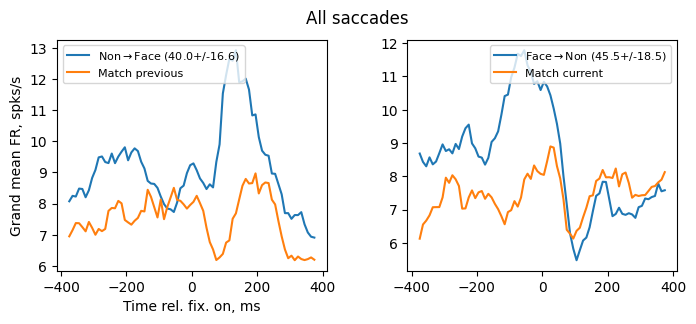

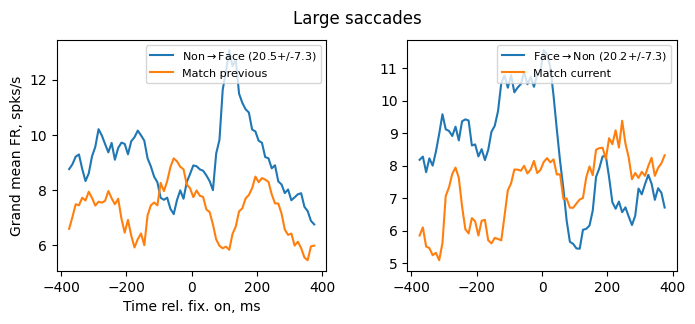

In [24]:
for scond, bytest_psth_mean_std in byscond_psth_mean_std.items():
    if not np.isfinite(bytest_psth_mean_std).any(): continue
    n = len(match_tests)
    fig, axs = plt.subplots(1, n, figsize=(4*n,3), squeeze=False)
    plt.subplots_adjust(wspace=0.3)
    axs = axs.ravel()
    for itest, psth_mean_std in enumerate(bytest_psth_mean_std):
        ax = axs[itest]
        test = match_tests[itest]
        nsaccs = byscond_nsaccs[scond][itest]
        for i in range(2):
            m = np.nanmean(psth_mean_std[i, 0], 1)
            s = np.nanstd(psth_mean_std[i, 0], 1)
            if i:
                lbl = f'Match {test[1]}'
            else:
                mn = nsaccs.mean()
                sn = nsaccs.std()
                lbl = r'$\rightarrow$'.join(test[0]) + f' ({mn:.1f}+/-{sn:.1f})'
            ax.plot(ts, m, label=lbl)
        ax.legend(fontsize=8)
    axs[0].set_xlabel('Time rel. fix. on, ms')
    axs[0].set_ylabel('Grand mean FR, spks/s')
    fig.suptitle(scond.capitalize() + ' saccades')

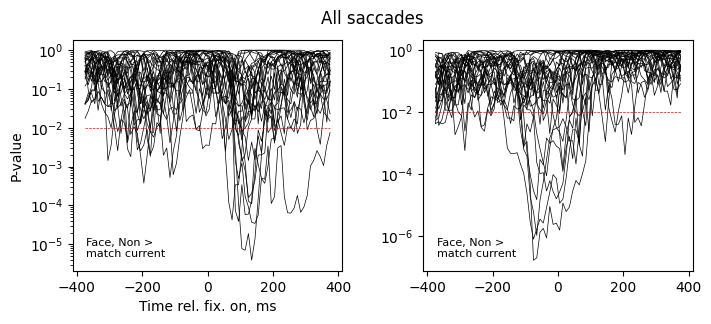

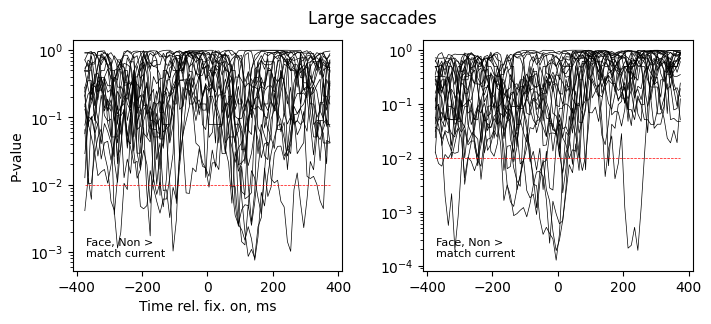

In [25]:
for scond, pvals in byscond_pvals.items():
    if not np.isfinite(pvals).any(): continue
    n = len(pvals)
    fig, axs = plt.subplots(1, n, figsize=(4*n,3), squeeze=False)
    plt.subplots_adjust(wspace=0.3)
    axs = axs.ravel()
    f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))
    for i, ax in enumerate(axs):
        vs = pvals[i]
        ax.plot(ts, pvals[i], c='k', lw=0.5);
        ax.set_yscale('log')
        ax.hlines(1e-2, ts.min(), ts.max(), ls='--', lw=0.5, color='r')
        ax.text(.05, .05, f'{f(test[0])} {dict(less="<",greater=">").get(test[2],"!=")}\nmatch {f(test[1])}',
                ha='left', va='bottom', transform=ax.transAxes, fontsize=8)
    fig.suptitle(scond.capitalize() + ' saccades')
    axs[0].set_xlabel('Time rel. fix. on, ms')
    axs[0].set_ylabel('P-value')